# Training the RPN signature on multi-center data

- This jupyter notebook is available on-line at:
  - https://github.com/spisakt/RPN-signature/blob/master/notebooks/1_multi-center_training.ipynb

- Input data for the notebook and non-standard code (PAINTeR library) is available in the repo:
  - https://github.com/spisakt/RPN-signature

- Raw MRI-data from study-centers 1 and 2 are available on OpenNeuro:
  - https://openneuro.org/datasets/ds002608/versions/1.0.1
  - https://openneuro.org/datasets/ds002609/versions/1.0.3

- Raw data from center 3 is available upon reasonable request.

### Imports

In [1]:
import sys
sys.path.append('../')
from PAINTeR import connectivity # in-house lib used for the RPN-signature
from PAINTeR import plot # in-house lib used for the RPN-signature
from PAINTeR import model # in-house lib used for the RPN-signature
import numpy as np # hi old friend
import pandas as pd

from sklearn.preprocessing import StandardScaler
from nilearn.connectome import ConnectivityMeasure

from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

from sklearn.linear_model import ElasticNet, Ridge
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneOut, KFold, GroupKFold, LeavePGroupsOut
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, explained_variance_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate

import scipy.stats as stats
import joblib

/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


## Load and merge behavioral data for all three centers (after exclusions)

In [2]:
df_bochum = pd.read_csv("../res/bochum_sample_excl.csv")
df_essen = pd.read_csv("../res/essen_sample_excl.csv")
df_szeged = pd.read_csv("../res/szeged_sample_excl.csv")
df_bochum['study']='bochum'
df_essen['study']='essen'
df_szeged['study']='szeged'
df=pd.concat((df_bochum, df_essen, df_szeged), sort=False)
df=df.reset_index()
df

,index,Unnamed: 0,ID,Excluded,exclusion_crit,Male,day_menses,Age,height,weight,...,weight..kg.,psq_moderate,psq_minor,PSQ20,PSQI,MDT_log_geom,Pulse_MRI,Pulse_QST,BDI,PSQ20_essen
0,0,0,4,0.0,NaN,1.0,NaN,25.552361,175.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,6,0.0,NaN,1.0,NaN,33.453799,183.0,80.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,7,0.0,NaN,1.0,NaN,26.119097,186.0,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,8,0.0,NaN,1.0,NaN,25.445585,180.0,72.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,9,0.0,NaN,0.0,6.0,22.573580,176.0,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,14,14,22,0.0,NaN,1.0,NaN,24.000000,185.0,82.0,...,NaN,27.0,11.0,6.0,1.0,-1.259900,73.0,76.0,5.0,24.0
87,15,15,24,0.0,NaN,1.0,NaN,22.000000,183.0,83.0,...,NaN,28.0,16.0,9.0,1.0,-1.913513,85.0,86.0,0.0,25.0
88,16,16,25,0.0,NaN,1.0,NaN,22.000000,195.0,77.0,...,NaN,20.0,9.0,11.0,NaN,-1.581106,88.0,91.0,1.0,25.0
89,17,17,28,0.0,NaN,0.0,5.0,23.000000,162.0,59.0,...,NaN,34.0,18.0,43.0,2.0,-1.145363,78.0,89.0,7.0,37.0


## Load preprocessed and scrubbed timeseries data

<AxesSubplot:>

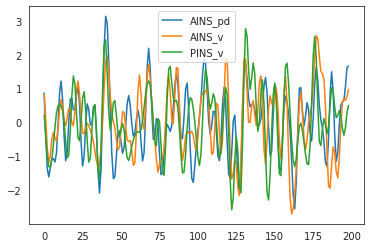

In [3]:
timeseries = []
perc_scrubbed = []
for i, f in enumerate(df['ts_file']):
    f = '..' + f.split('/..')[1]
    f_scrub = f.split('.tsv')[0] + '-scrubbed.tsv'
    
    ts = pd.read_csv(f_scrub).iloc[:,1:] # here we can omit global signal...
    
    fd_file = df["fd_file"].values[i]
    fd_file = '..' + fd_file.split('/..')[1]
    fd = pd.read_csv(fd_file).values.ravel().tolist()
    fd = [0] + fd 
    
    perc_scrubbed.append(100 - 100*len(ts.shape)/len(fd) )
    timeseries.append(ts.values)
    
# double check visually
sub_idx=10  # modify this for a different subject
# modify below for different regions (see the next cell for region names)
pd.DataFrame(timeseries[sub_idx], columns=ts.columns.values).loc[:, ['AINS_pd', 'AINS_v', 'PINS_v']].plot()

## Load region and module names for the MIST122 atlas

In [4]:
labels=ts.columns.values
l = pd.read_csv('../data/atlas_relabeled.tsv', sep="\t")
modules=np.insert(l['modules'].values, 0, "GlobSig")
print('Region names:\n', labels)

Region names:
 ['GlobSig' 'CER6_p' 'CER7ab' 'R_CERCR2_p' 'CER9_v' 'CER6_a' 'L_CERCR2_a'
 'CER9_d' 'CER9_m' 'CER7b_m' 'L_CERCR2_p' 'CER7b_l' 'N' 'CERCR1' 'CER6_d'
 'CER5' 'R_CERCR2_a' 'POsul_d' 'POsul_v' 'VMPFcor_p' 'R_MTgyr_a'
 'L_ANGgyr' 'L_MTgyr_p' 'L_MTgyr_a' 'DMPFC_ar' 'L_SFsul_a' 'DMPFcor_ac'
 'PCcor' 'POsul' 'L_IPlob' 'PGACcor' 'VMPFcor_a' 'PRC_d' 'SFgyr_ad'
 'L_IPlob.1' 'R_ANGgyr' 'PRC_v' 'R_MTgyr_p' 'PRC_d.1' 'R_MFgyr_a'
 'L_DVIS_v' 'SPlob' 'R_VLPFcor' 'FUSgyr_vl' 'R_IFsul' 'FP' 'R_DVIS_v'
 'L_FP_l' 'SPlob.1' 'L_MFgyr_pc' 'L_VLPFcor' 'OCCTgyr_l' 'ACcor_d'
 'L_MFgyr_pr' 'R_MFgyr_p' 'R_IPsul' 'L_IFsul' 'DVIS_s' 'FUSgyr_dl'
 'R_SFsul' 'R_IPlob' 'R_FP_l' 'R_PORB' 'DMPFcor_p' 'L_IPsul' 'L_MFgyr_a'
 'DVIS_vl' 'CAUDNH_NACC' 'COLsul' 'LORBgyr' 'ITgyr' 'STgyr_a' 'MORBgyr'
 'PINS_v' 'TP' 'HIPP' 'AMY' 'PIsul' 'CERVM' 'L_MOTnet_dl' 'MOTnet_am'
 'R_MOTnet_dl' 'MOTnet_m' 'MOTnet_ml' 'MOTnet_vl' 'MOTnet_l' 'l_PCsul'
 'CNGsul_p' 'PUT_p' 'AINS_pd' 'CAUDN_d' 'AINS_v' 'FEF' 'PCsul_d' 'IMsul'
 'ST

## Calculate functional connectivity as partial correlation

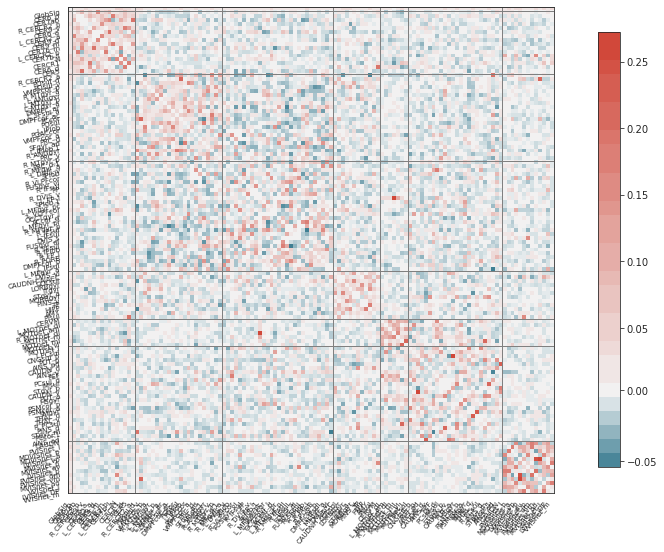

In [5]:
correlation_measure = ConnectivityMeasure(kind='partial correlation', vectorize=True, discard_diagonal=True)
X = correlation_measure.fit_transform(timeseries) # these are the features
joblib.dump(X, "../res/multi-center/all_features.joblib")

# double-check the mean matrix visually
mat=correlation_measure.mean_
#mat=mat[1:, 1:] #fisrt row and column is global signal
mat[range(mat.shape[0]), range(mat.shape[0])] = 0 # zero diag
plot.plot_matrix(mat, labels, modules)

## Create groups to balance the cross-validations across centers

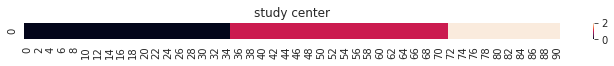

35 37 19


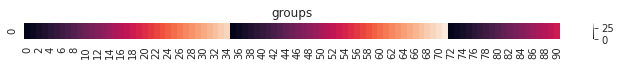

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
       13, 14, 15, 16, 17, 18])

In [6]:

plt.figure(figsize=(12, 0.3))
sns.heatmap([df.study.astype("category").cat.codes.values]).set_title('study center')
plt.show()
n_szeged = np.sum(df.study == 'szeged') # size of the smallest study
n_essen = np.sum(df.study == 'essen')
n_bochum = np.sum(df.study == 'bochum')
print(n_bochum, n_essen, n_szeged)

groups=np.zeros(len(df), dtype=int)

g=0
i=0
while i < n_bochum:
    groups[i] = g
    #groups[i+1] = g
    i += 1
    g += 1
    
g=0
i=n_bochum
while i < n_bochum+n_essen:
    groups[i] = g
    #groups[i+1] = g
    i += 1
    g += 1
g=0
i=n_bochum+n_essen
while i < len(df):
    groups[i] = g
    i += 1
    g += 1
    
plt.figure(figsize=(12, 0.3))
sns.heatmap([groups]).set_title('groups')
plt.show()

groups

## Pain sensitivity as target variable

In [7]:
y = df.HPT

## Define model to be trained

In [8]:
# an oversimplified factory-function, defining the model to be trained:
def pipe_scale_fsel_elnet(scaler=preprocessing.RobustScaler(),
                          fsel=SelectKBest(f_regression),
                          model=ElasticNet(max_iter=100000),
                          p_grid={'fsel__k': [25, 50, 100, 1000, 3000],
                              'model__alpha': [.001, .005, .01, .05, .1, .5, 1, 5],
                              'model__l1_ratio': [0.0001, .25, .5, .75, 0.9999]         
                                   }):
                                      
    mymodel = Pipeline(
        [
         ('fsel', fsel),
         ('scaler', scaler),
         ('model', model)])
    return mymodel, p_grid

In [9]:
model, p_grid = pipe_scale_fsel_elnet()

## Do a non-nested, balanced cross validation, to optimize hyperparameters, then retain the final multi-center model

In [10]:
cv = GroupKFold(30)
clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=cv,
                   scoring="neg_mean_squared_error", verbose=True, return_train_score=False,
                   n_jobs=-1)
clf.fit(X, y, groups=groups)

cv_pred = cross_val_predict(clf.best_estimator_, X, y, cv=cv, groups=groups, n_jobs=-1)                                 

Fitting 30 folds for each of 200 candidates, totalling 6000 fits


### Print out some non-nested accuracy eestiomates and plot the non-nested prediction (overly optimistic).

**** Non-nested analysis ****
** Best hyperparameters: {'fsel__k': 3000, 'model__alpha': 0.005, 'model__l1_ratio': 0.9999}
** Score on full data as training set:	-0.0017913830025941553
** Score on mean as model: -7.979906291510686
** Best Non-nested cross-validated score on test:	-5.960867653574719
XXXXX Explained Variance: 0.2530153317820153


/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


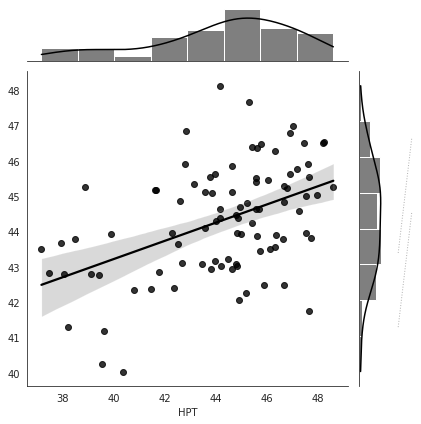

In [11]:
print("**** Non-nested analysis ****")
print("** Best hyperparameters: " + str(clf.best_params_))

print("** Score on full data as training set:\t" + str(-mean_squared_error(y_pred=clf.best_estimator_.predict(X), y_true=y)))
print("** Score on mean as model: " + str(-mean_squared_error(np.repeat(y.mean(), len(y)), y)))
print("** Best Non-nested cross-validated score on test:\t" + str(clf.best_score_))
print("XXXXX Explained Variance: " + str(
        1 - clf.best_score_ / -mean_squared_error(np.repeat(y.mean(), len(y)), y)))
plot.plot_prediction(y, cv_pred, sd=True, covar=[])

### Save finalized model and non-nested predictions (just in case)

In [12]:
joblib.dump(clf.best_estimator_, '../res/multi-center/HPT_finalized_model_multi-center.joblib')
# save NON-nested cv-predictions
np.savetxt("../res/multi-center/HPT_nonnested_cv_pred_full_GroupKFold30.csv", cv_pred, delimiter=",")

## Do a nested, balanced cross-validation, to obtain unbiased accuracy estimates

In [13]:
# we use the same model
model, p_grid = pipe_scale_fsel_elnet()

outer_cv = GroupKFold(30)
inner_cv = GroupKFold(30)                                    
clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=inner_cv,
                   scoring="neg_mean_squared_error", verbose=True, return_train_score=False,
                   n_jobs=-1)

all_models = []
best_params = []
predicted = np.zeros(len(y))
nested_scores_train = np.zeros(outer_cv.get_n_splits(X))
nested_scores_test = np.zeros(outer_cv.get_n_splits(X))   
                                    
print("model\tinner_cv mean score\touter vc score")
i=0
for train, test in outer_cv.split(X, y, groups=groups):
    group_train = groups[train]  
    
    clf.fit(X[train], y[train], groups=group_train)
                                    
    print('cv:', i, str(clf.best_params_) + " " + str(clf.best_score_) + " " + str(clf.score(X[test], y[test])))
                                    
    all_models.append(clf.best_estimator_)
    best_params.append(clf.best_params_)
    
    predicted[test] = clf.predict(X[test])
                                    
    nested_scores_train[i] = clf.best_score_
    nested_scores_test[i] = clf.score(X[test], y[test])
    i = i+1

model	inner_cv mean score	outer vc score
Fitting 30 folds for each of 200 candidates, totalling 6000 fits
cv: 0 {'fsel__k': 50, 'model__alpha': 0.1, 'model__l1_ratio': 0.9999} -5.546239388911332 -14.51033945143403
Fitting 30 folds for each of 200 candidates, totalling 6000 fits
cv: 1 {'fsel__k': 3000, 'model__alpha': 0.005, 'model__l1_ratio': 0.9999} -6.697465358466027 -2.3437342784692996
Fitting 30 folds for each of 200 candidates, totalling 6000 fits
cv: 2 {'fsel__k': 1000, 'model__alpha': 0.1, 'model__l1_ratio': 0.9999} -6.78225135147586 -2.233371970667435
Fitting 30 folds for each of 200 candidates, totalling 6000 fits
cv: 3 {'fsel__k': 1000, 'model__alpha': 0.01, 'model__l1_ratio': 0.9999} -5.569768007814651 -8.477055546126895
Fitting 30 folds for each of 200 candidates, totalling 6000 fits
cv: 4 {'fsel__k': 1000, 'model__alpha': 0.05, 'model__l1_ratio': 0.9999} -6.90404245935667 -2.269043940144915
Fitting 30 folds for each of 200 candidates, totalling 6000 fits
cv: 5 {'fsel__k': 

/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07982618689398624, tolerance: 0.06980396988636363
  model = cd_fast.enet_coordinate_descent(
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08246746655232637, tolerance: 0.06746243576470588
  model = cd_fast.enet_coordinate_descent(
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0751184396653957, tolerance: 0.0646983095238095
  model = cd_fast.enet_coordinate_descent(
/home/tspisak/src/RPN-signature/v

cv: 12 {'fsel__k': 3000, 'model__alpha': 0.1, 'model__l1_ratio': 0.9999} -6.87822725385958 -2.285943329053532
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08351521664155825, tolerance: 0.07207709818181818
  model = cd_fast.enet_coordinate_descent(
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09096275973347004, tolerance: 0.0703285959090909
  model = cd_fast.enet_coordinate_descent(
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07772436018224262, tolerance: 0.06825266352941176
  model = cd_fast.enet_coordinate_descent(
/home/tspisak/src/RPN-signature/

cv: 13 {'fsel__k': 3000, 'model__alpha': 0.05, 'model__l1_ratio': 0.9999} -5.744637631460642 -8.728378293597265
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08618788578911643, tolerance: 0.07082492443181818
  model = cd_fast.enet_coordinate_descent(
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07896207674606653, tolerance: 0.06799935247058822
  model = cd_fast.enet_coordinate_descent(
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09069305014085365, tolerance: 0.07006747105882352
  model = cd_fast.enet_coordinate_descent(
/home/tspisak/src/RPN-signature

cv: 14 {'fsel__k': 1000, 'model__alpha': 0.1, 'model__l1_ratio': 0.9999} -6.410516123746324 -1.2773259421927015
Fitting 30 folds for each of 200 candidates, totalling 6000 fits
cv: 15 {'fsel__k': 1000, 'model__alpha': 0.001, 'model__l1_ratio': 0.9999} -7.149256434440809 -6.318937357730569
Fitting 30 folds for each of 200 candidates, totalling 6000 fits
cv: 16 {'fsel__k': 1000, 'model__alpha': 0.001, 'model__l1_ratio': 0.9999} -6.76461834720219 -4.285743592053078
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08530156119066293, tolerance: 0.06635173609195402
  model = cd_fast.enet_coordinate_descent(
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08367729276628492, tolerance: 0.06782187952941177
  model = cd_fast.enet_coordinate_descent(
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07560289662808696, tolerance: 0.06806857571428572
  model = cd_fast.enet_coordinate_descent(
/home/tspisak/src/RPN-signature

cv: 17 {'fsel__k': 3000, 'model__alpha': 0.005, 'model__l1_ratio': 0.9999} -5.701871475088482 -4.954116640464448
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08511262329425143, tolerance: 0.07139511090909091
  model = cd_fast.enet_coordinate_descent(
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08040860410976271, tolerance: 0.06801263816091953
  model = cd_fast.enet_coordinate_descent(
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07920062203999748, tolerance: 0.06625134894117646
  model = cd_fast.enet_coordinate_descent(
/home/tspisak/src/RPN-signature

cv: 18 {'fsel__k': 3000, 'model__alpha': 0.1, 'model__l1_ratio': 0.9999} -6.455328878551719 -3.3167132042214718
Fitting 30 folds for each of 200 candidates, totalling 6000 fits
cv: 19 {'fsel__k': 25, 'model__alpha': 0.001, 'model__l1_ratio': 0.0001} -5.984250402815998 -20.747652974452887
Fitting 30 folds for each of 200 candidates, totalling 6000 fits
cv: 20 {'fsel__k': 1000, 'model__alpha': 0.01, 'model__l1_ratio': 0.9999} -6.382807389893625 -13.11444184915877
Fitting 30 folds for each of 200 candidates, totalling 6000 fits
cv: 21 {'fsel__k': 3000, 'model__alpha': 0.005, 'model__l1_ratio': 0.9999} -5.559118799941867 -12.896627985828848
Fitting 30 folds for each of 200 candidates, totalling 6000 fits
cv: 22 {'fsel__k': 3000, 'model__alpha': 0.005, 'model__l1_ratio': 0.9999} -6.816609731480763 -11.911008266391393
Fitting 30 folds for each of 200 candidates, totalling 6000 fits
cv: 23 {'fsel__k': 1000, 'model__alpha': 0.001, 'model__l1_ratio': 0.9999} -6.143770912654396 -18.6961553472007

/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07618146398946657, tolerance: 0.06044984035714287
  model = cd_fast.enet_coordinate_descent(
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08692782656574854, tolerance: 0.06930057247058823
  model = cd_fast.enet_coordinate_descent(
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08167171246609561, tolerance: 0.06653068416666666
  model = cd_fast.enet_coordinate_descent(
/home/tspisak/src/RPN-signature

cv: 28 {'fsel__k': 3000, 'model__alpha': 0.1, 'model__l1_ratio': 0.9999} -6.130652932181404 -10.931314304498649
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08348488170290566, tolerance: 0.06743429488372092
  model = cd_fast.enet_coordinate_descent(
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07951253831880173, tolerance: 0.07109315952941174
  model = cd_fast.enet_coordinate_descent(
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08325168121129024, tolerance: 0.06687952809523807
  model = cd_fast.enet_coordinate_descent(
/home/tspisak/src/RPN-signature

cv: 29 {'fsel__k': 100, 'model__alpha': 0.1, 'model__l1_ratio': 0.9999} -7.543637290208834 -1.49374586815587


### Print out the unbiased, nested estimates and plot the (unbiased) nested-cv predictions

*** Score on mean as model:	-7.979906291510686
** Mean score in the inner crossvaludation (inner_cv):	-6.411406753695525
** Mean Nested Crossvalidation Score (outer_cv):	-7.664301646083951
Explained Variance: 0.03954991874559821
Correlation: 0.22733348630998704


/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


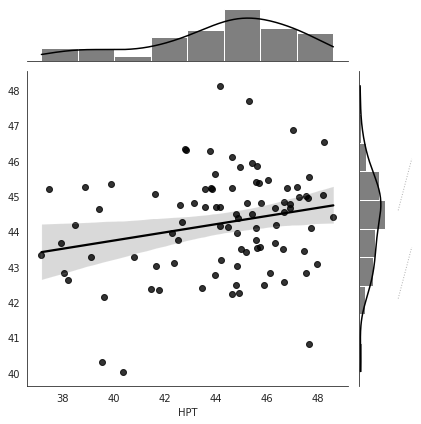

In [14]:
print("*** Score on mean as model:\t" + str(-mean_squared_error(np.repeat(y.mean(), len(y)), y)))
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))
print("Explained Variance: " +  str( 1- nested_scores_test.mean()/-mean_squared_error(np.repeat(y.mean(), len(y)), y) ))
print("Correlation: " + str(np.corrcoef(y, predicted)[0,1]))
                                    
plot.plot_prediction(y, predicted, sd=True, covar=[])

### Save the nested-cv predictions

In [15]:
# save nested predictions
np.savetxt("../res/multi-center/HPT_nested_cv_pred_full_GroupKFold30.csv", predicted, delimiter=",")